## Imbalanced Datasets with imbalanced-learn 

### 1. Introduction
Machine learning classsification algorithms tend to produce unsatisfactory results when trying to classify unbalanced datasets. The number of observations in the class of interest is very low compared to the total number of observations. Examples of applications with such datasets are customer churn identification, financial fraud identification, identification of rare diseases, detecting defects in manufacturing, etc. Classifiers give poor results on such datasets as they favor the majority class, resulting in a high missclassification rate for the minority class of interest. For example, when faced with a credit card fraud dataset where only 1% of transactions are fraudulent, a classification algorithm such as logistic regression would tend to predict that all transactions are legitimate, resulting in 99% accuracy. Needless to say, such an algorithm would be of little value. In real world cases, collecting more data might be an option and should be explored if possible. 

To improve the prediction, our machine learning algorithms would require a roughly equal number of observations from each class. This new dataset can be constructed by resampling our observations. [Imbalanced learn](https://github.com/scikit-learn-contrib/imbalanced-learn) is a [scikit-learn](http://scikit-learn.org/stable/) compatible package which implements various resampling methods to tackle imbalanced datasets. In this post we explore the usage of imbalanced-learn and the various resampling techniques that are implemented within the package.  


### 2. Dataset
For our study we will use the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset that has been made available by the [ULB Machine Learning Group](http://mlg.ulb.ac.be) on Kaggle. The dataset contains almost 285k observations. The available features are `Time`, anonymous features `V1` to `V28`(which are the results of PCA transformation) and `Amount` while the classification is given by `class`. Only 0.17% of the transactions are fraudulent. 

In [79]:
import pandas as pd
df=pd.read_csv(r'C:\Users\david\Documents\MITB\Portfolio\creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 3. Exploratory Data Analysis (EDA)
Although our goals is to see how the imbalanced-learn package work, we will still need to explore the data and correct for any issues as in any machine learning pipeline. In order to speed up the process, I referred to the kaggle kernals below:  

* https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now/notebook
* https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

Of particular note, the `Time` and `Amount` are skewed:

C:\Users\david\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


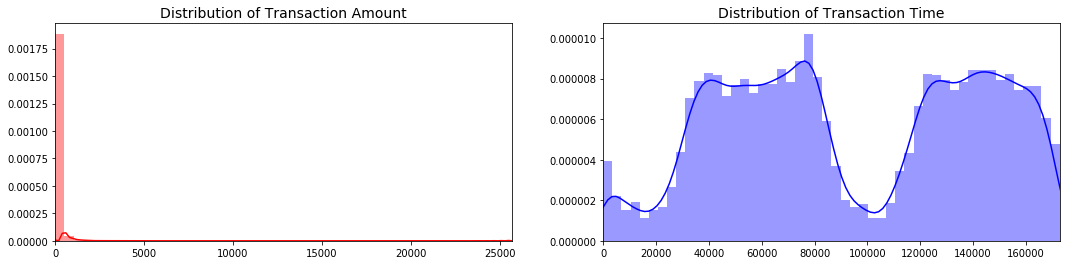

In [63]:
import seaborn as sns 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

The transaction amount is heaviliy skewed towards small transactions and should be scaled. One option would be to use a log transformation on the data set. The transaction time seems to follow a night and day pattern with the number of transactions going down at night. As such I choose not to scale the `time` variable

C:\Users\david\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


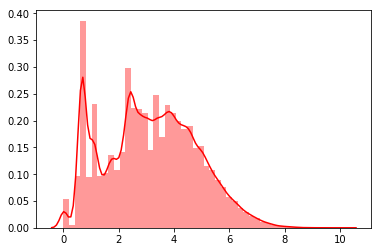

In [80]:
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler

df['scaled_amount'] = np.log(df['Amount']+1)
rob_scaler = RobustScaler()
#df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

#df.drop(['Amount'], axis=1, inplace=True)
df.drop(['Time','Amount'], axis=1, inplace=True)


scale_amount_val = df['scaled_amount'].values
sns.distplot(scale_amount_val, color='r')
plt.show()


C:\Users\david\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


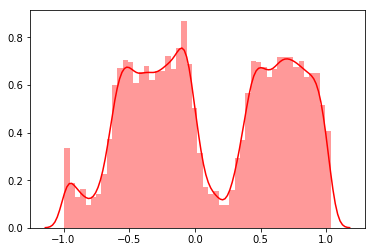

In [81]:
scale_time_val = df['scaled_time'].values
sns.distplot(scale_time_val, color='r')
plt.show()

### 4. Splitting the data into training and validation subsets 

We split the data into the training and validation datasets cross-validation with a 70:30 ratio. This is a simple hold out method. Note that the training should be done on the rebalanced/resampled training dataset while the **evaluation should be done one the original holdout validation dataset.** 

In [82]:
from sklearn.model_selection import train_test_split
y=df['Class']
x=df.drop(['Class'], axis=1)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3, stratify=y)

### 5. Various techniques for resampling the training dataset

Here we explore the various options to rebalance the training dataset. The methods can either:
* Under-sample the majority class
* Over-sample the minority class.
* Combine over and under-sampling.
* Create ensemble balanced sets.

#### 5.1 Undersampling

There are various algorithms implemented in imbalanced-learn that supports undersampling the majority class. They can be divided into generative and selective algorithms; generative algos try to summarize the majority class and then the samples are drawn from this generated data instead of the actual majority class observations. On the other hand, selective algorithms use various heuristics to select (or reject) samples to be drawn from the majority class. There are many undersampling algorithms and we will not run through all of them. 

##### Undersampling with Random Under Sampler
The simpliest selective under-sampler is the random under sampler **`RandomUnderSampler`**; we select the majority class randomly. Bootstrapping is possible by setting the parameter `replacement` to `True`. 

In [83]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
x_rus, y_rus = rus.fit_sample(x_train, y_train)

In [84]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=10).fit_transform(x_rus)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=10).fit_transform(x_rus)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=10).fit_transform(x_rus)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 1.6e+01 s
PCA took 0.004 s
Truncated SVD took 0.002 s


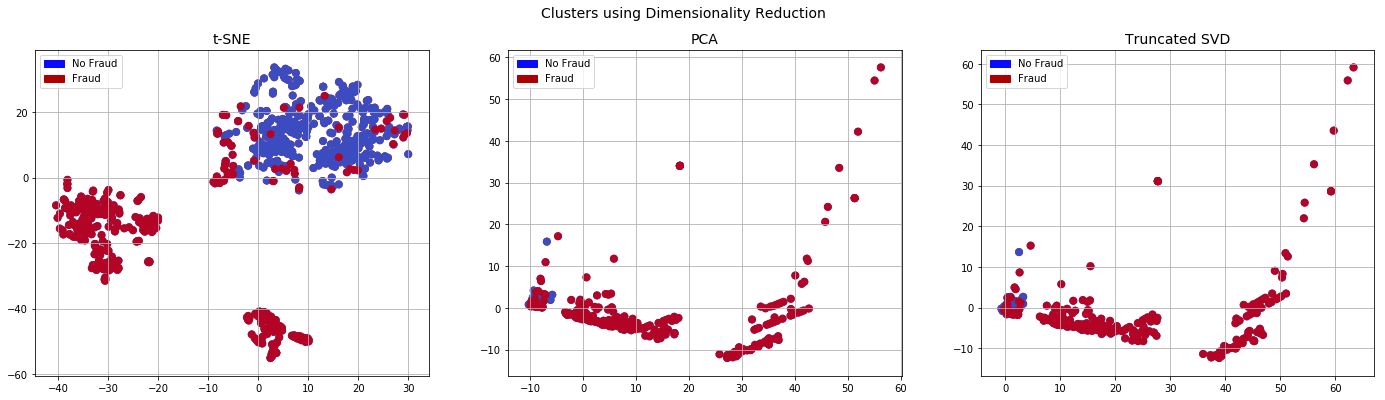

In [85]:
import matplotlib.patches as mpatches
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_rus == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_rus == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_rus == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_rus == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y_rus == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y_rus == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

This post was written as a Jupyter Notebook. Click [here]() to view it

##### Under Sampling with Tomek Links

In [86]:
from imblearn.under_sampling import TomekLinks
tomekl = TomekLinks(random_state=0,n_jobs=3)
x_tomekl, y_tomekl = rus.fit_sample(x_train, y_train)

In [87]:
# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=10).fit_transform(x_tomekl)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=10).fit_transform(x_tomekl)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=10).fit_transform(x_tomekl)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 1.7e+01 s
PCA took 0.004 s
Truncated SVD took 0.002 s


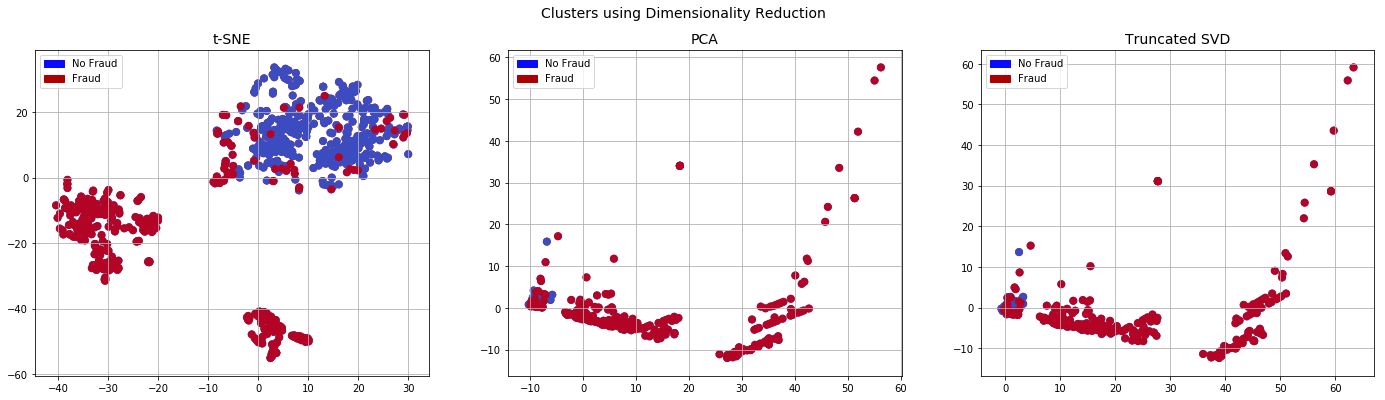

In [88]:
import matplotlib.patches as mpatches
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_tomekl == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_tomekl == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_tomekl == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_tomekl == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y_tomekl == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y_tomekl == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

### References

@article{JMLR:v18:16-365,
author  = {Guillaume  Lema{{\^i}}tre and Fernando Nogueira and Christos K. Aridas},
title   = {Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning},
journal = {Journal of Machine Learning Research},
year    = {2017},
volume  = {18},
number  = {17},
pages   = {1-5},
url     = {http://jmlr.org/papers/v18/16-365}
}